In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from pycbc import psd as psd_func
from pycbc.filter import sigma
from simple_pe.waveforms import make_waveform, calc_f_gen, calculate_ecc_SNR, two_ecc_harms_SNR
from calcwf import match_hn

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [12]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


In [37]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [51]:
# Loop over distance along degeneracy line
data_ecc_SNRs = []
trial_ecc_SNRs = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s = np.linspace(0, 0.5, 21)
for i, e10 in enumerate(e10s):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs.append(data_ecc_SNR)
    
    # Calculate eccentric SNR of trial waveform
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_ecc_SNR = calculate_ecc_SNR(params['total_mass'], params['inverted_mass_ratio'],
                                      params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                      psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=False)
    trial_ecc_SNRs.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

21 complete out of 21

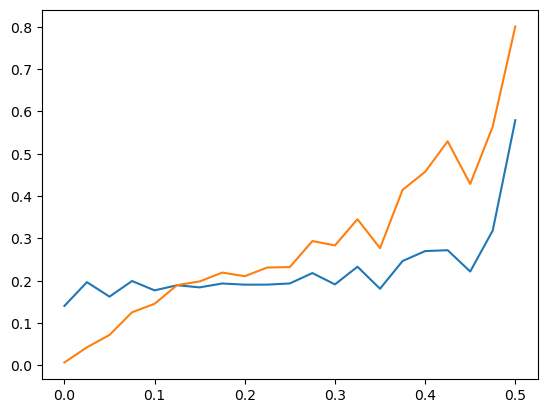

In [40]:
# Plot ecc SNRs two ecc harms in both
plt.plot(e10s, data_ecc_SNRs)
plt.plot(e10s, np.abs(trial_ecc_SNRs))

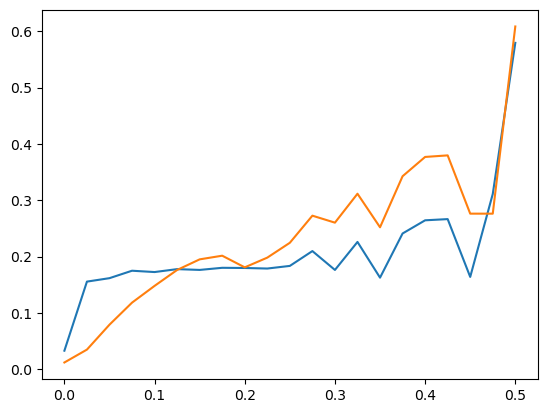

In [42]:
# Plot ecc SNRs one ecc harm in both
plt.plot(e10s, data_ecc_SNRs)
plt.plot(e10s, np.abs(trial_ecc_SNRs))

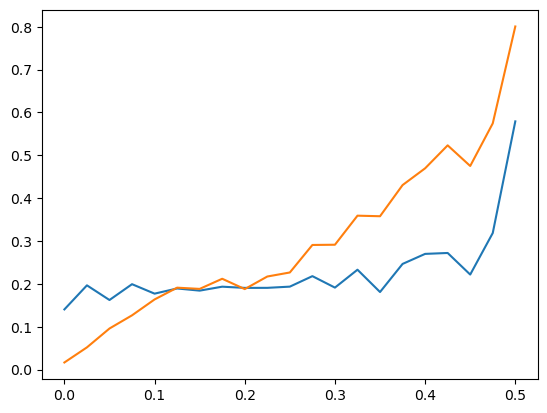

In [44]:
# Plot ecc SNRs one ecc harm for target MA, two ecc harms for SNR
plt.plot(e10s, data_ecc_SNRs)
plt.plot(e10s, np.abs(trial_ecc_SNRs))

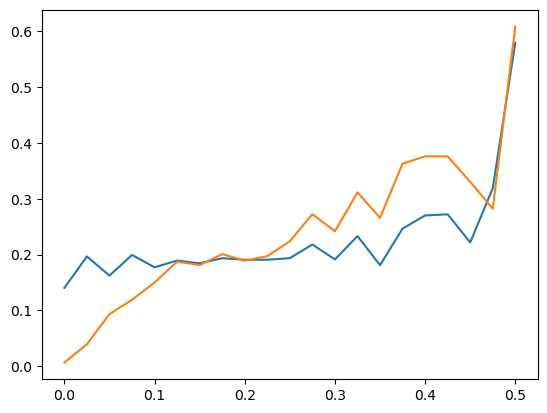

In [52]:
# Plot ecc SNRs two ecc harms for target MA, one ecc harm for SNR
plt.plot(e10s, np.abs(data_ecc_SNRs))
plt.plot(e10s, np.abs(trial_ecc_SNRs))

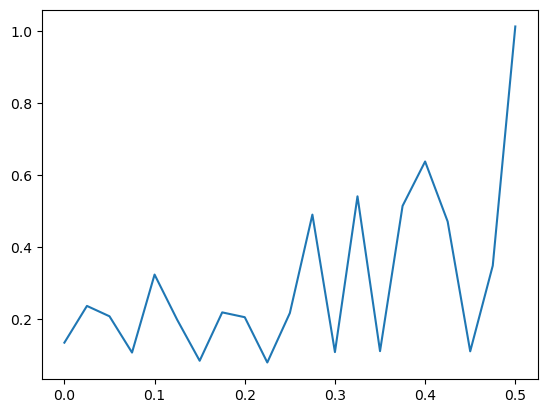

In [54]:
plt.plot(e10s, np.abs(np.array(data_ecc_SNRs)-np.array(trial_ecc_SNRs)))